In [1]:
# importing
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:


df = pd.read_excel("saleeee.xlsx")

df.head(10)
df.info()
df1= df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Row ID        9994 non-null     float64       
 1   Order Date    9994 non-null     datetime64[ns]
 2   Customer ID   9994 non-null     object        
 3   Segment       9994 non-null     object        
 4   Product ID    9994 non-null     object        
 5   Category      9994 non-null     object        
 6   Sub-Category  9994 non-null     object        
 7   Product Name  9994 non-null     object        
 8   Sales         1048575 non-null  float64       
 9   Quantity      9994 non-null     float64       
 10  Discount      9994 non-null     float64       
 11  Profit        1048575 non-null  float64       
 12  month         9994 non-null     object        
 13  year          9994 non-null     float64       
dtypes: datetime64[ns](1), float64(6), object(7)
memory

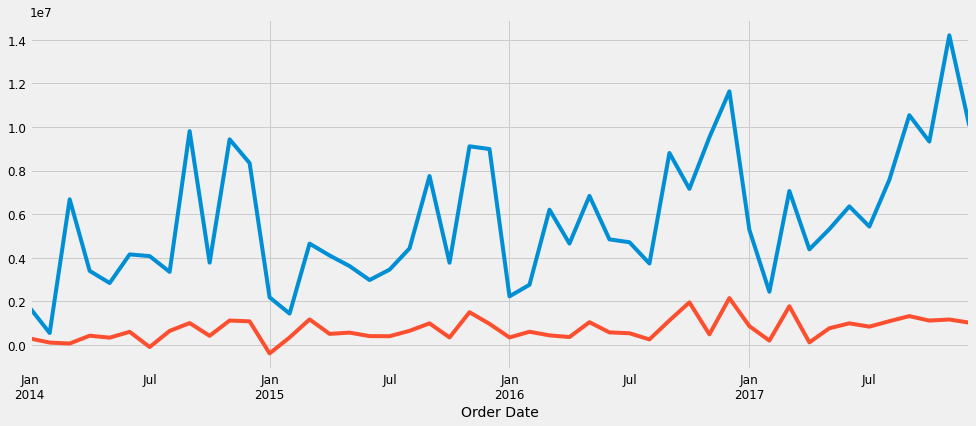

In [3]:
#sales and profit of total sales
df = pd.read_excel("saleeee.xlsx")

cols = ['Row ID','Customer ID', 'Segment','Category', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount']
df1.drop(cols, axis=1, inplace=True)

df1 = df1.sort_values('Order Date')
df1.isnull().sum()
df1 = df1.set_index('Order Date')
y1 = df1['Sales'].resample('MS').sum()
y2 = df1['Profit'].resample('MS').sum()
y1.plot(figsize=(15, 6))
y2.plot(figsize=(15, 6))
plt.show()


In [4]:
def profit(prof):
      x= prof
      prof = df.loc[df['Category'] == "{}".format(prof)]
    
    
      cols = ['Row ID','Sales','Customer ID', 'Segment','Product ID', 'Category','Sub-Category', 'Product Name', 'Quantity', 'Discount']
      prof.drop(cols, axis=1, inplace=True)
      prof = prof.sort_values('Order Date')
      prof.isnull().sum()
      prof = prof.set_index('Order Date')

      y_fur = prof['Profit'].resample('MS').sum()
      y_fur.plot(figsize=(15, 6))
      plt.plot()
      plt.xlabel('Time')
      plt.ylabel('Profit in Rs')
      plt.legend(["{}".format(x)])
 

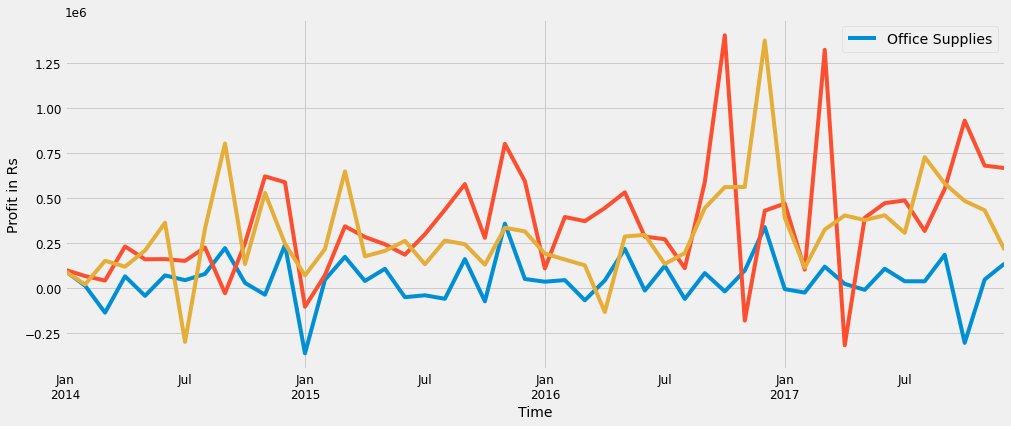

In [5]:
#fix individual legend in everything as of now it shows only office supplies
profit('Furniture')

profit('Technology')
profit('Office Supplies')

In [6]:
#show sales 
def sales(sale_category):
     x= sale_category
     sale_category = df.loc[df['Category'] == "{}".format(sale_category)]
     cols = ['Row ID', 'Customer ID', 'Segment', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
     sale_category.drop(cols, axis=1, inplace=True)
     sale_category = sale_category.sort_values('Order Date')
     sale_category.isnull().sum()
     sale_category= sale_category.groupby('Order Date')['Sales'].sum().reset_index()
     sale_category = sale_category.set_index('Order Date')
     y = sale_category['Sales'].resample('MS').sum()
  
     y.plot(figsize=(15, 6))
     plt.show()
     decompose(y)
     predict(y)
     
     
    

In [7]:
def decompose(y):
    from pylab import rcParams
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    plt.show()

In [8]:
def predict(y):
    #I have no idea this step
# Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    warnings.filterwarnings("ignore") # specify to ignore warning messages

# #sarima model to find best AIC, lower the AIC better

#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(y,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)

#                 results = mod.fit()

#                 print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#             except:
#                 continue
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    # for the graph
    ax = y['2014':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()
        #fthere is a gap cause the monthly summary comes at the start of december, find a way to connect red and blue graph
    #can fix it with prophet but will not look so good
    pred_uc = results.get_forecast(steps=100)
    pred_ci = pred_uc.conf_int()
    ax = y.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.show()


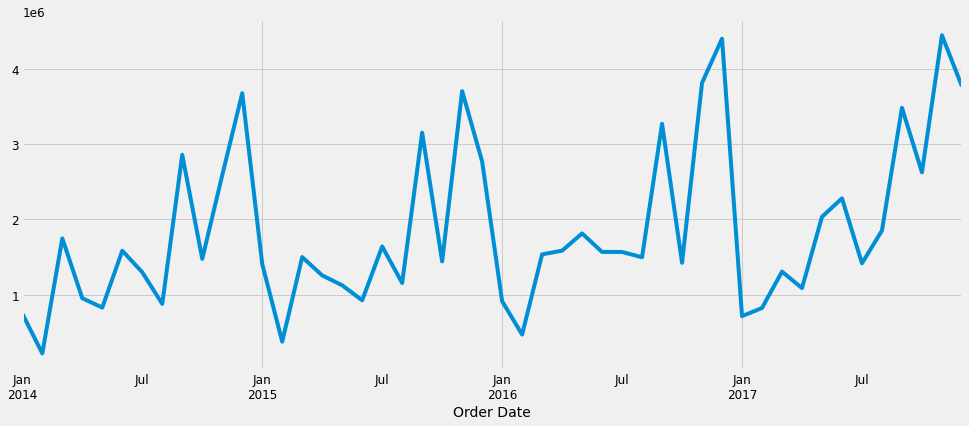

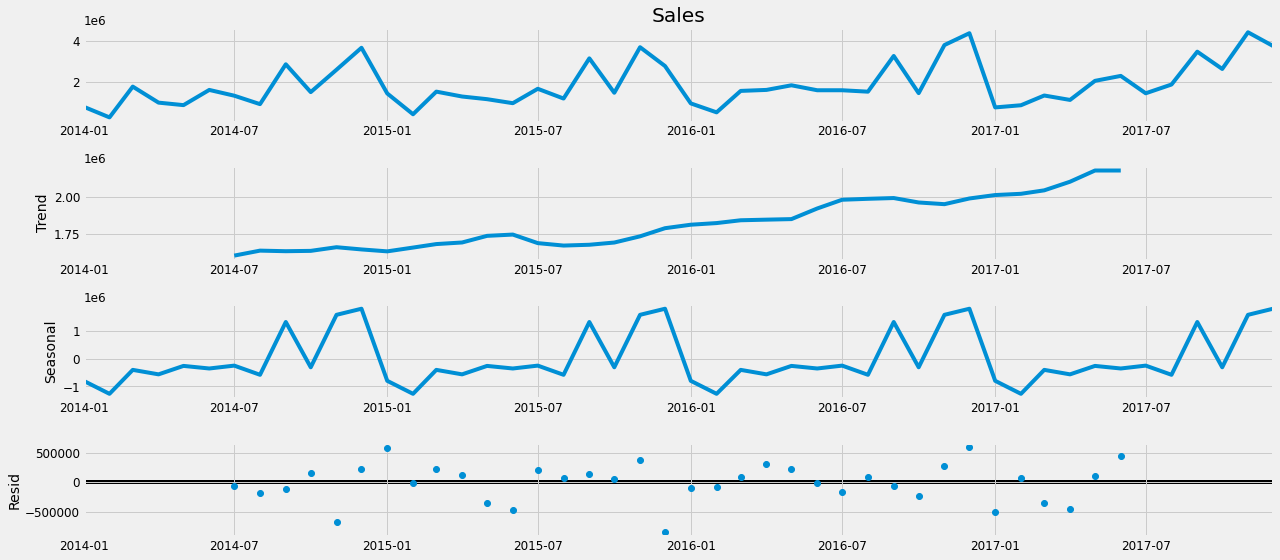

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1259      0.669     -0.188      0.851      -1.437       1.185
ma.L1         -0.7952      0.272     -2.924      0.003      -1.328      -0.262
ar.S.L12      -0.7283      0.541     -1.346      0.178      -1.788       0.332
ma.S.L12       0.3818      0.909      0.420      0.675      -1.401       2.164
sigma2      4.045e+11   8.18e-13   4.94e+23      0.000    4.04e+11    4.04e+11


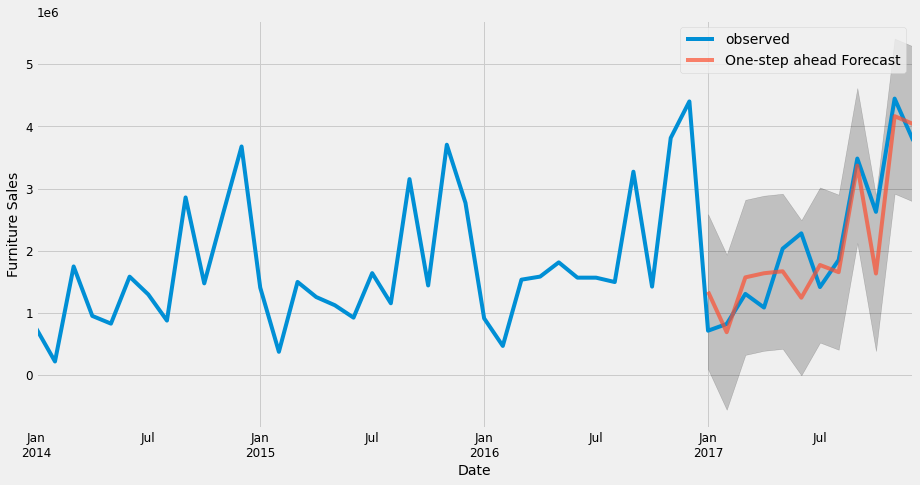

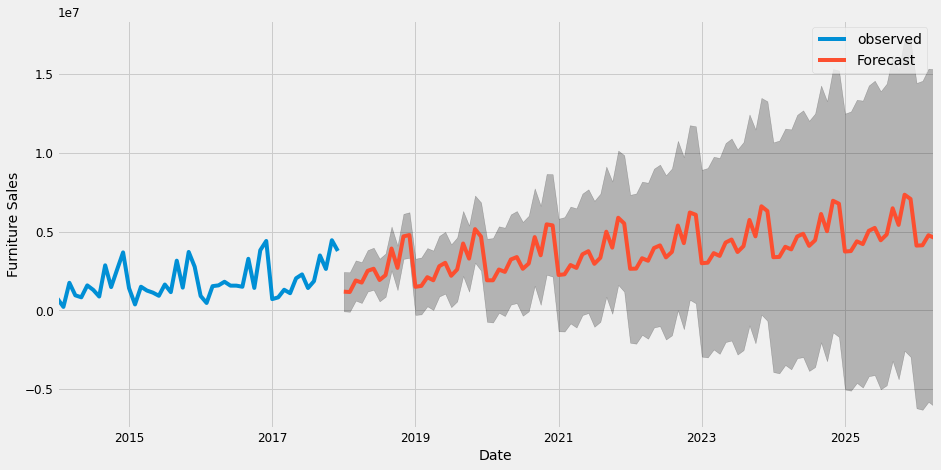

In [9]:
sales("Furniture")



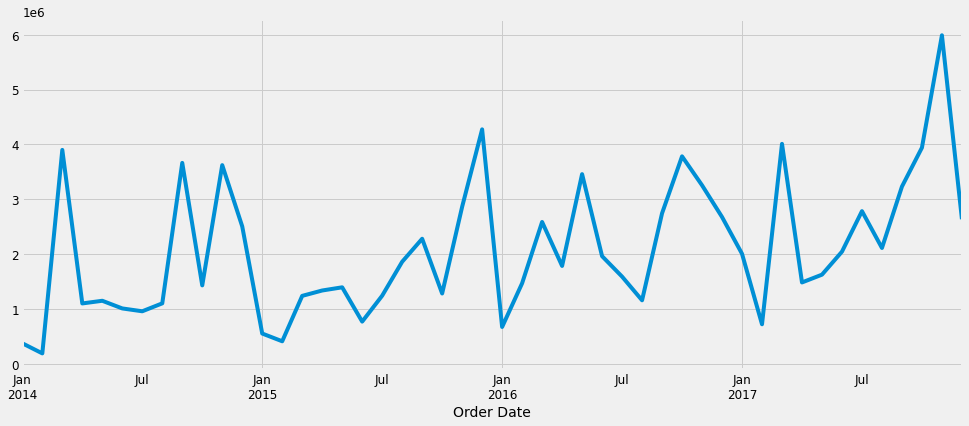

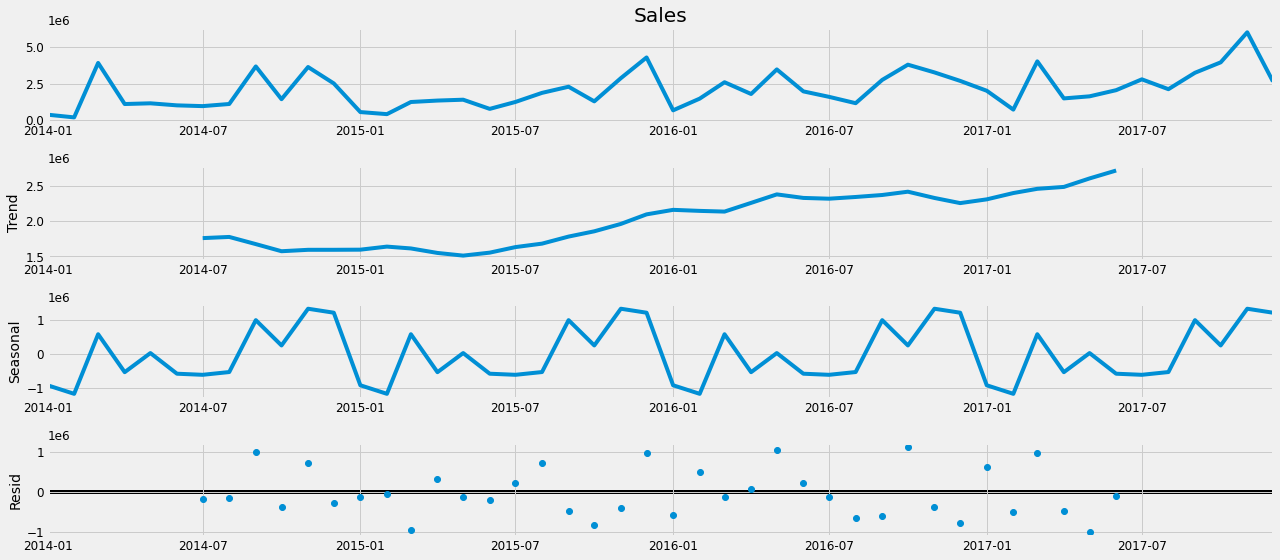

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1338      0.497     -0.269      0.788      -1.108       0.841
ma.L1         -0.9547      0.086    -11.120      0.000      -1.123      -0.786
ar.S.L12      -0.3173      0.687     -0.462      0.644      -1.663       1.029
ma.S.L12      -0.4914      0.567     -0.867      0.386      -1.602       0.619
sigma2      1.472e+12   1.34e-13    1.1e+25      0.000    1.47e+12    1.47e+12


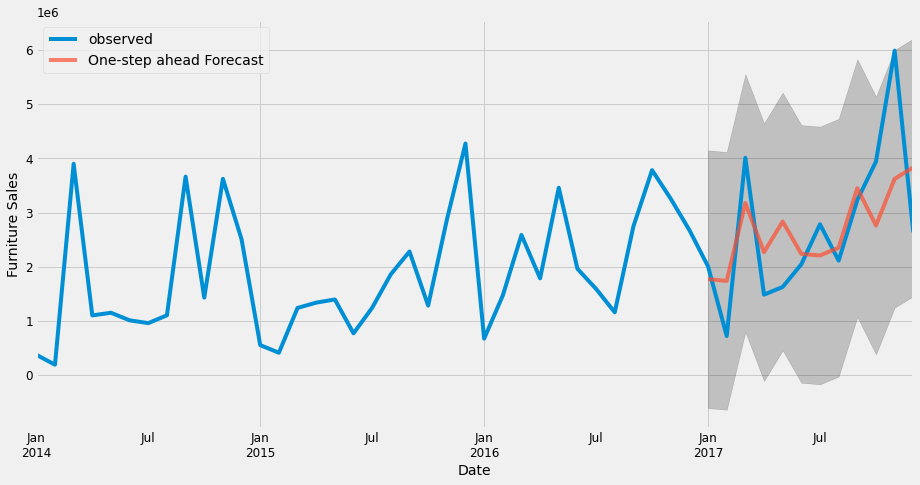

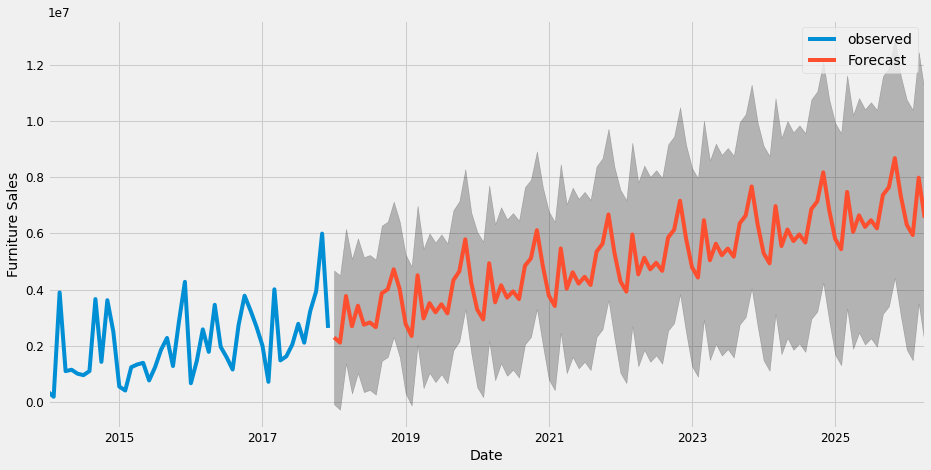

In [10]:
sales("Technology")

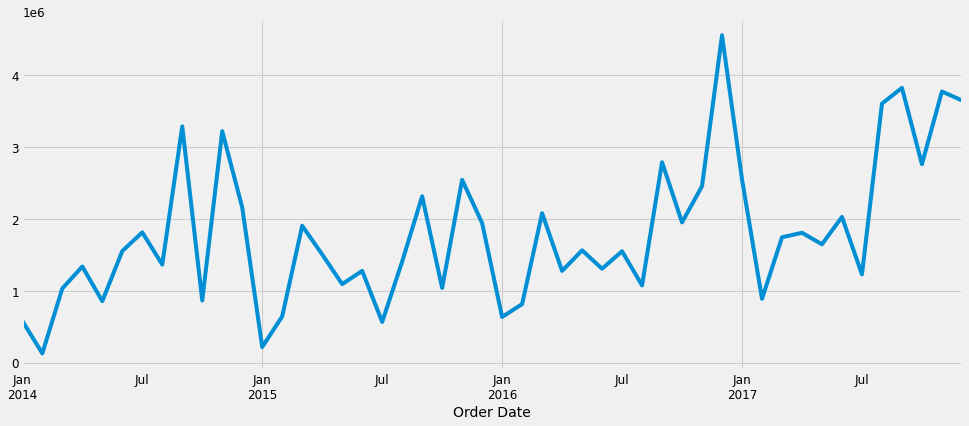

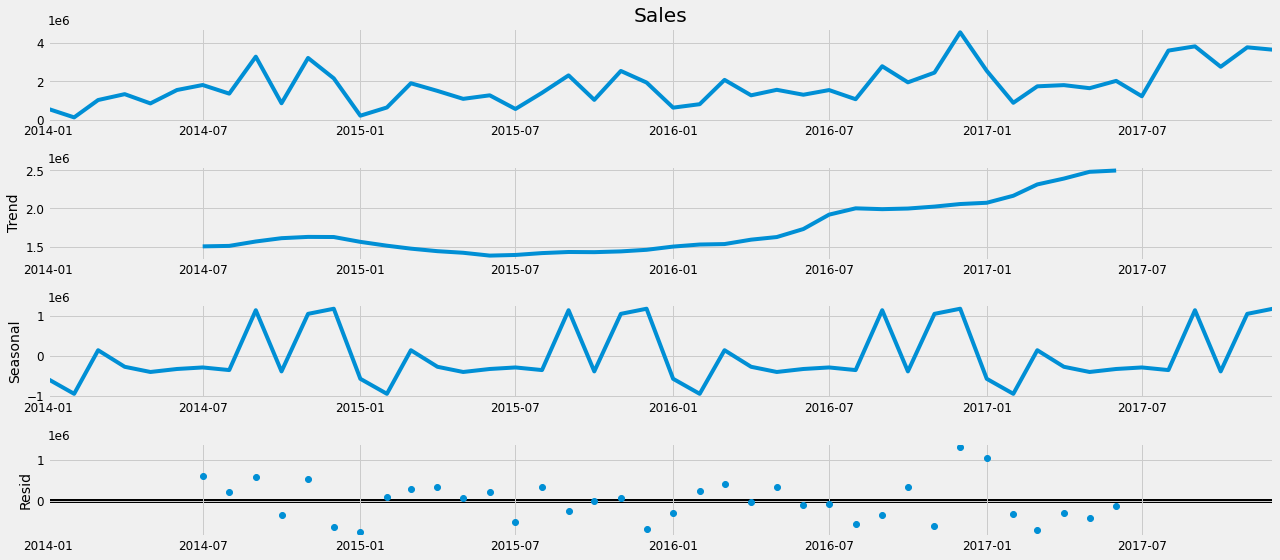

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2606      0.531      0.491      0.623      -0.779       1.300
ma.L1         -0.9896      0.070    -14.067      0.000      -1.127      -0.852
ar.S.L12      -0.3360      1.002     -0.335      0.737      -2.300       1.628
ma.S.L12      -0.4935      0.642     -0.769      0.442      -1.751       0.764
sigma2      9.133e+11   4.59e-13   1.99e+24      0.000    9.13e+11    9.13e+11


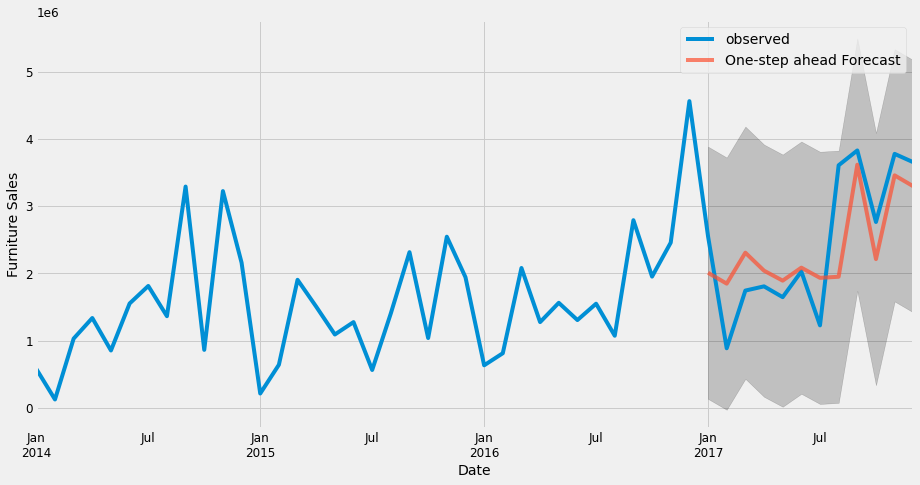

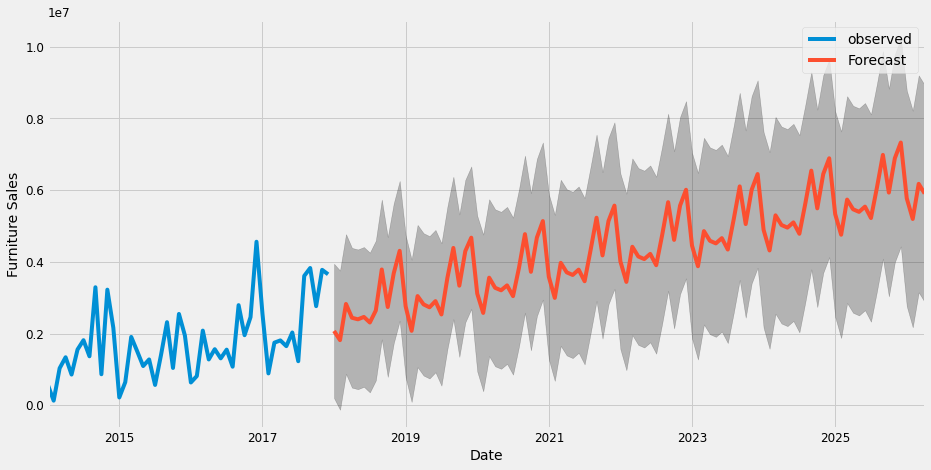

In [11]:
sales("Office Supplies")

In [12]:
pwd

'/home/shreya/Downloads/TSA-using-Arima-Model-master'